# LPC VOCODER

## Libraries

In [47]:
import numpy as np
import scipy.io.wavfile
from scipy.signal.windows import hann
from scipy.signal import resample
from numpy import floor
from scipy.signal import lfilter
import scipy.signal 
from numpy.random import randn
import matplotlib.pyplot as plt
import librosa
import IPython.display


In [48]:
def display_audio(data, fs):
	IPython.display.display(IPython.display.Audio(data, rate=fs))

## import audio

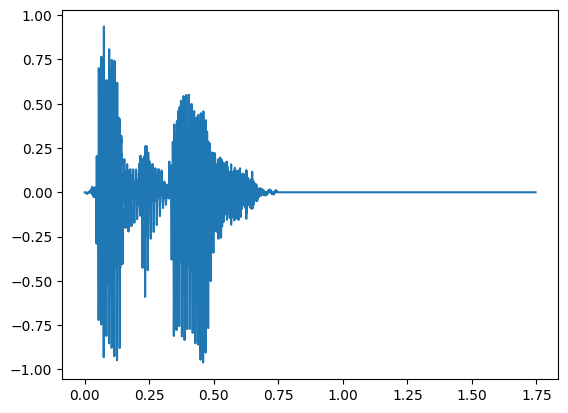

In [49]:
fs = 8000
x_test, fs = librosa.load("odbiemrz.wav", sr=fs, mono=True)
t = np.linspace(0, len(x_test)/fs, len(x_test))
w = hann(512)
plt.plot(t, x_test)
display_audio(x_test, fs)

# Enkodowanie sygnału

## Podzielenie sygnału na bloki

generate blocks shape: (53, 512)


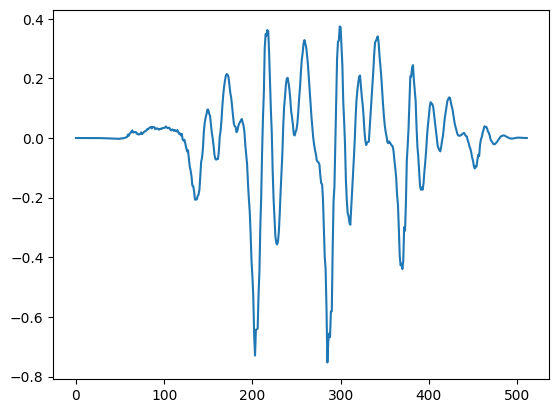

In [50]:

def create_overlapping_blocks(input, window, R = 0.5):
    n = len(input)
    nw = len(window)
    step = int(floor(nw * (1 - R)))
    nb = int(floor((n - nw) / step) + 1)

    B = np.zeros((nb, nw))

    for i in range(nb):
        offset = i * step
        B[i, :] = window * input[offset : nw + offset]

    return B

Blocks = create_overlapping_blocks(x_test, w)
print("generate blocks shape: %s"%str(Blocks.shape))
plt.plot(Blocks[10, :]);


## Detekcja częstotliwości

prawdziwe: 88.88888888888889 z funkcji 88.88888888888889


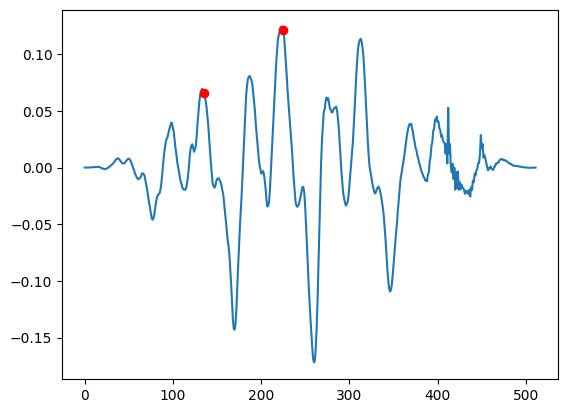

In [140]:
def tonal_detection(input, fs):
	f_low = 80
	f_high = 960
	cor = np.correlate(input, input, 'same')
	cor_max = np.max(np.abs(cor))
	if cor_max==0: return 0
	cor = cor/cor_max

	peaks_idx, gowno_jakies = scipy.signal.find_peaks(cor, 0.4)
	if len(peaks_idx) < 2: return 0
	
	first_peak_idx = np.argmax(cor[peaks_idx])

	idx_diff = peaks_idx[first_peak_idx+1] - peaks_idx[first_peak_idx]
	detect_frequency = fs/idx_diff

	if detect_frequency > f_high: return 0
	if detect_frequency < f_low: return 0
	return detect_frequency


test = Blocks[5, :]
plt.plot(test)
idx1 = 135
idx2 = 225
plt.plot(idx1, test[idx1], 'ro')
plt.plot(idx2, test[idx2], 'ro')
display_audio(test, fs)
f1 = tonal_detection(test, fs)
f2 = fs/(idx2-idx1)
print("prawdziwe:", f2, "z funkcji", f1)


# for bl in Blocks:
	# tonal_detection(bl, 8000)


## Enkodowanie

In [141]:
# tworzenie macierzy autokorelacji
def make_matrix_R(x_sig, p):
    n = len(x_sig)
    
    xz_sig = np.concatenate([x_sig[::-1], np.zeros(p)])

    R = np.zeros((n - 1, p))
    for i in range(n - 1):
        offset = n - 1 - i
        R[i, :] = xz_sig[offset : offset + p]
    return R

# rozwiązanie predykcji liniowej
def solve_lpc(x_sig, p):
    Rss = make_matrix_R(x_sig, p)

    a = np.linalg.lstsq(Rss, x_sig[1:].T)[0]

    e = x_sig[1:] - np.dot(Rss, a)
    g = np.var(e)

    return [a, g]

# returns:
# A - filter coeff for each time block 
# G - signal amplitude for each block 
# F - signal frequency for each block (0 if noise)
def lpc_encode(sig, p, win, fs):
    
    sig_blocks = create_overlapping_blocks(sig, win)
    n_time = sig_blocks.shape[0]

    A = np.zeros([p, n_time])
    G = np.zeros([1, n_time])
    F = np.zeros([1, n_time])

    for timeIdx in range(n_time):
        [coeff, sig_amp] = solve_lpc(sig_blocks[timeIdx, :], p)
        freq = tonal_detection(sig_blocks[timeIdx, :], fs)

        A[:, timeIdx] = coeff
        G[:, timeIdx] = sig_amp
        F[0, timeIdx] = freq

    return [A, F, G]

# Dekodowanie sygnału

In [152]:
def add_overlapping_blocks(B, w, R = 0.5):
	[count, nw] = B.shape
	step = floor(nw * R)

	n = int((count-1) * step + nw)

	x = np.zeros((n, ))

	for i in range(count):
		offset = int(i * step)
		x[offset : nw + offset] += B[i, :]

	return x


t = []
def run_source_filter(a, f, t, fs, g, block_size):
	if f == 0:
		src = np.sqrt(g)*randn(block_size, 1) # noise
	else:
		t = np.linspace(0, block_size/fs, block_size)
		src = np.sqrt(g) * scipy.signal.sawtooth(2*np.pi*f*t, 1).reshape(block_size, 1) # tone
		
	b = np.concatenate([np.array([-1]), a])

	x_hat = lfilter([1], b.T, src.T).T

	# convert Nx1 matrix into a N vector
	return np.squeeze(x_hat)

def lpc_decode(A, F, G, w):

	[ne, n] = G.shape
	nw = len(w)
	[p, _] = A.shape

	B_hat = np.zeros((n, nw))

	for i in range(n):
		B_hat[i,:] = run_source_filter(A[:, i], F[0, i], t, fs, G[:, i], nw)

	# recover signal from blocks
	x_hat = add_overlapping_blocks(B_hat, np.ones([1,n]))
	
	return x_hat

xhat = lpc_decode(A, F, G, w)

# Test LPC


/tmp/ipykernel_17439/3461051603.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = np.linalg.lstsq(Rss, x_sig[1:].T)[0]


ORYGINAL


LPC


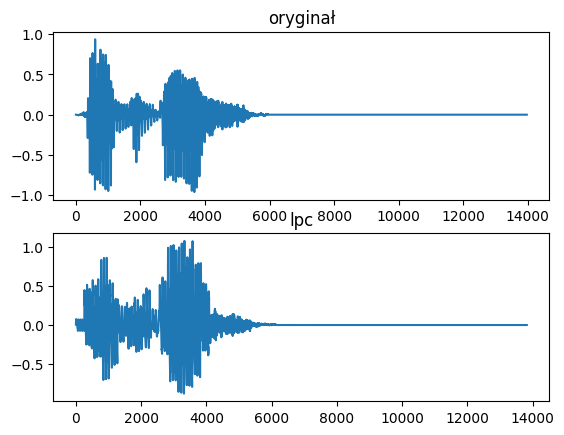

In [153]:
fs = 8000
x_test, fs = librosa.load("odbiemrz.wav", sr=fs, mono=True)
t = np.linspace(0, len(x_test)/fs, len(x_test))
w = hann(512)

A, F, G = lpc_encode(x_test, 12, w, fs)

xhat = lpc_decode(A, F, G, w)
print('ORYGINAL')
display_audio(x_test, fs)
print('LPC')
display_audio(xhat, fs)

plt.subplot(211)
plt.title("oryginał")
plt.plot(x_test)
plt.subplot(212)
plt.title("lpc")
plt.plot(xhat)
